In [1]:
# from model import classification_m
from data.data import data_preprocessing, load_pretrained_embedding, apply_tokenizer
from models.model import LSTM_model, BidirLSTM_model 
from utility.utility import plot_confusion_matrix, plot_precision_recall_curve, plot_ROC, plot_data_balance, data_analysis, get_classification_report, model_performance_curves
import numpy as np
import tensorflow 
from tensorflow.keras.callbacks import TensorBoard
import datetime, os

In [2]:
# run data preprocessing 
train_df_path = './labeledTrainData.tsv'
test_df_path = "./testData.tsv"
train_corpus, test_corpus, y_train, y_test = data_preprocessing(train_df_path, test_df_path)

(22504, 6)


d:\ML_task_IMDB_data\data\data.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["rating"] > 7, "Rating"] = 1
d:\ML_task_IMDB_data\data\data.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"] = df["Rating"].astype(int)


In [3]:
# use pretrained embedding and process the train and test data
embedding_matrix, tokenizered_corpus, voc_length = load_pretrained_embedding('./glove.6B.50d.txt', train_corpus)
embedding_matrix_test, tokenizered_corpus_test, voc_length_test = load_pretrained_embedding('./glove.6B.50d.txt', test_corpus)

In [4]:
def start_training(use_LSTM, max_words, matrix, vec_size, dropout_p, hidden_neurons, lstm_neurons):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if use_LSTM:
        print("running the model with LSTM layer")
        model = LSTM_model(max_words, matrix, vec_size, dropout_p, hidden_neurons, lstm_neurons)
        model_type = "LSTM"
        save_runs = 'D:\ML_task_IMDB_data\runs\LSTM_model'
    else:
        print("running model with bidirectional layer")
        model = BidirLSTM_model(max_words, matrix, vec_size, dropout_p, hidden_neurons, lstm_neurons)
        model_type = "Bidir_LSTM"
        save_runs = 'D:\ML_task_IMDB_data\runs\Bidir_LSTM_model'


    checkpoint_cb = tensorflow.keras.callbacks.ModelCheckpoint(f"D:/ML_task_IMDB_data/training_weights/{model_type}_classification_{current_time}.keras", save_best_only=True)
    early_stopping_cb = tensorflow.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)
    
    return model, checkpoint_cb, early_stopping_cb, model_type, save_runs
    

In [5]:
model, checkpoint_cb, early_stopping_cb, model_type, save_runs = start_training(use_LSTM  = False, max_words = voc_length, matrix = embedding_matrix, vec_size = 50, dropout_p=0.5,hidden_neurons=8,lstm_neurons=16)

start_time = datetime.datetime.now()

model_history = model.fit(
    tokenizered_corpus,  # Training data
    y_train,             # Training labels
    batch_size=64,
    epochs=40,
    verbose=1,
    validation_split=0.3,  # Percentage of training data to use for validation
    # callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_callback]
    callbacks=[checkpoint_cb, early_stopping_cb],
    shuffle = True
)

end_time = datetime.datetime.now()
training_time = end_time - start_time
print(f"time required for the training is { training_time}")

running model with bidirectional layer

Epoch 1/40


247/247 [==============================] - 24s 81ms/step - loss: 0.5019 - accuracy: 0.7519 - val_loss: 0.3960 - val_accuracy: 0.8279
Epoch 2/40
247/247 [==============================] - 18s 74ms/step - loss: 0.3761 - accuracy: 0.8349 - val_loss: 0.3876 - val_accuracy: 0.8408
Epoch 3/40
247/247 [==============================] - 21s 84ms/step - loss: 0.3421 - accuracy: 0.8534 - val_loss: 0.3573 - val_accuracy: 0.8442
Epoch 4/40
247/247 [==============================] - 21s 84ms/step - loss: 0.3171 - accuracy: 0.8625 - val_loss: 0.3907 - val_accuracy: 0.8224
Epoch 5/40
247/247 [==============================] - 19s 78ms/step - loss: 0.3024 - accuracy: 0.8744 - val_loss: 0.3869 - val_accuracy: 0.8486
Epoch 6/40
247/247 [==============================] - 21s 83ms/step - loss: 0.2851 - accuracy: 0.8806 - val_loss: 0.3624 - val_accuracy: 0.8522
Epoch 7/40
247/247 [==============================] - 22s 88ms/step - loss: 0.2702 - accuracy:

In [6]:
score = model.predict(tokenizered_corpus_test)

710/710 [==============================] - 13s 17ms/step


In [7]:
# threshold can be adjust 
threshold = 0.5
y_pred = (score > threshold).astype(int)

confusion matrix for Bidir_LSTM


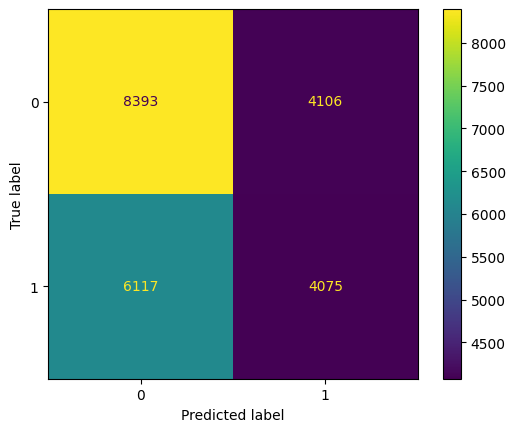

In [8]:
plot_confusion_matrix(y_test, y_pred, model_type)

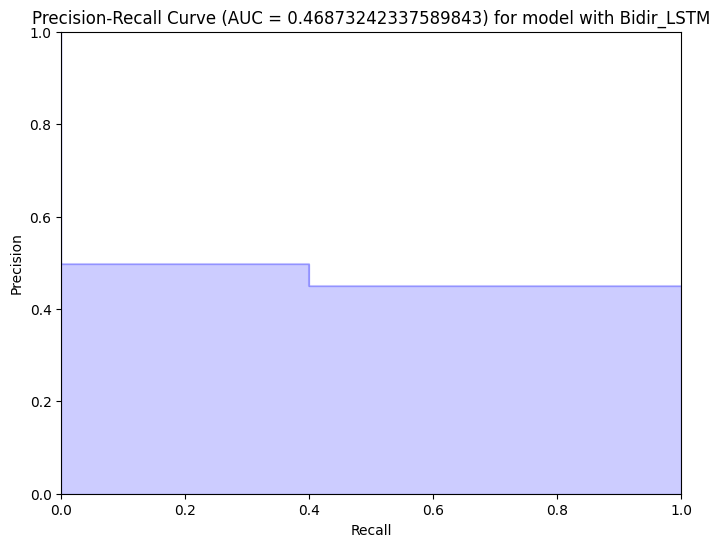

In [9]:
plot_precision_recall_curve(y_test, y_pred,model_type)

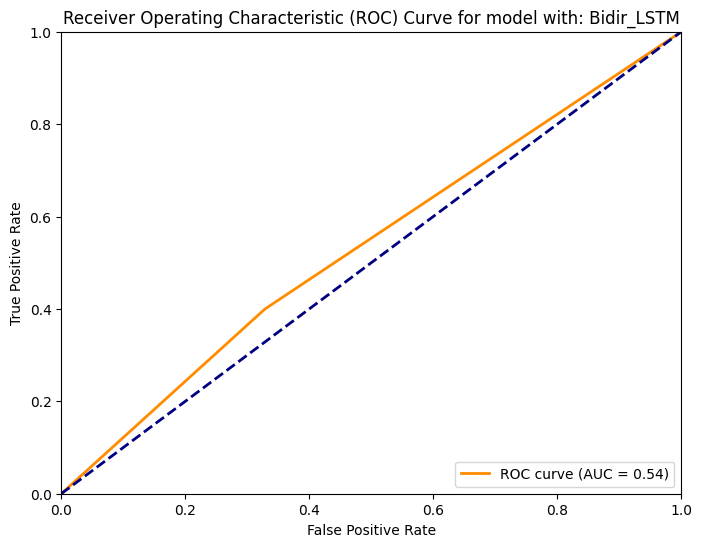

In [10]:
plot_ROC(y_test, y_pred, model_type)

In [11]:
cls_accuracy, cls_report = get_classification_report(y_test, y_pred)

In [12]:
print(f"the classifiation accuray is: { round(cls_accuracy, 3)}")
print("the classifiation accuray is: {cls_report}")
print(cls_report)

the classifiation accuray is: 0.549
the classifiation accuray is: {cls_report}
              precision    recall  f1-score   support

           0       0.58      0.67      0.62     12499
           1       0.50      0.40      0.44     10192

    accuracy                           0.55     22691
   macro avg       0.54      0.54      0.53     22691
weighted avg       0.54      0.55      0.54     22691



**For 40 epochs using LSTM layer, achieved the 0.559 accuracy. Model is saved at D:\ML_task_IMDB_data\training_weights\LSTM_classification_20240129-184420.keras**

**For 40 epochs using Bidir LSTM layer, achieved the 0.549 accuracy. Model is saved at training_weights\Bidir_LSTM_classification_20240129-191100.keras**

In [13]:
import matplotlib.pyplot as plt

OSError: [Errno 22] Invalid argument: 'D:\\ML_task_IMDB_data\runs\\Bidir_LSTM_model\\Bidir_LSTM_accuracy_20240129-191948.png'

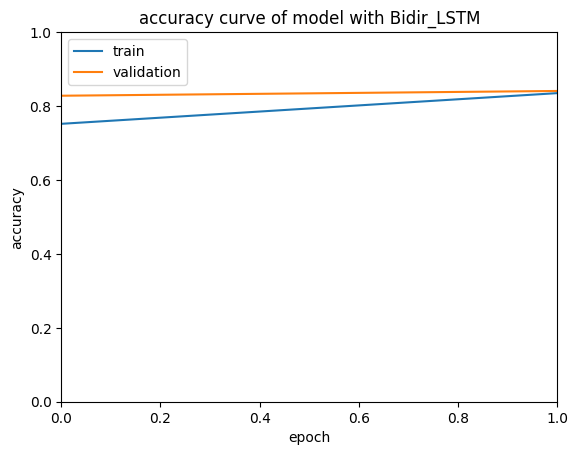

In [14]:
model_performance_curves(model_history, performance_para="accuracy", tr_performance_para="accuracy", val_performance_para="val_accuracy", model_type = model_type, path = save_runs)

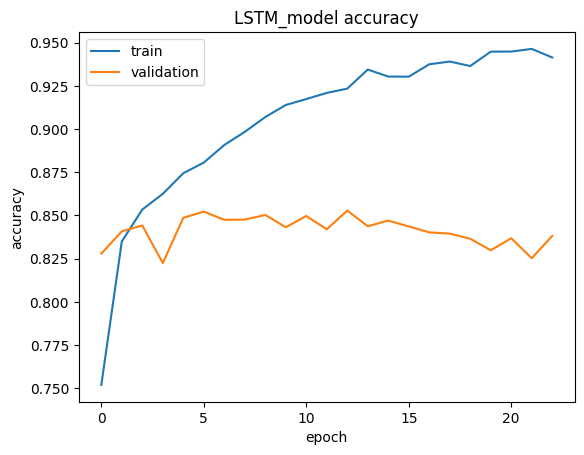

In [15]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Bidir_LSTM_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("Accuracy curve LSTM.pdf", format = 'pdf')
plt.show()

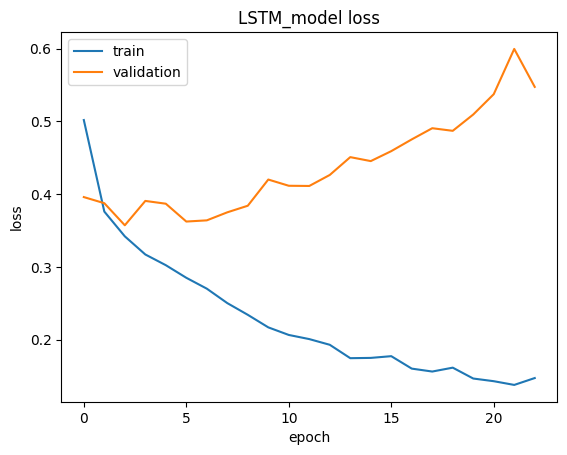

In [16]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('LSTM_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("loss curve LSTM.pdf", format = 'pdf')
plt.show()

**Explain the performance differences on validation (from labeledTrainData) and test (testData) datasets.**

*Commenting on the model performance using validation and test data, if we look at accuarcy and loss curve for LSTM model spefially, we can notice that it has really well trained without overfitting, but not yet reached global minima. But when predictions has been made on test data there are large number of FP and FN, the model has achieved the average precesion and recall. One of the reason for this is availability of limitted training data. Same Has been happed in case of the Bi*


***Comment on the performance***

*The lstm model has used the lstm layer along with dropoutp and regularization parameters, from the accuracy (.\accuracy curve LSTM 40epoch.pdf.png) and loss curve (.\loss curve LSTM 40epoch.pdf.png) we can see the LSTM model is well regularized. Althrough it hasn't converged to gloabl minimuma but upon futher traininng we can expect to get converged. which has shows that model is not overfitting but need to trained futher.*


*The model with bidirectional LSTM layers has been trained with regularization and hidden dense layer, just by looking at the accuracy curve (.\accuracy curve bidir_LSTM 40epoch.pdf.png) and loss curve (loss curve Bidir_LSTM 40epoch.pdf.png) we can use that model is overfitting because accuarcy and loss curves are moving in opposite to each other. In other words model is being trained well but failed to perform on the validation dataset. this can be again improve upon the regularizing the model well.*